#QIBA Digital Phantoms: Elastic Mesh Refinement
##Introduction
Bo (Mayo) compared our elastic simulation results between LS-DYNA and ABAQUS using the uniform mesh with 0.25 mm node spacing.  Those simulations matched well, but we want to make sure that the spectral content of the elastic simulations is not influenced by the mesh element density.  I have run all 48 cases using a 0.1 mm node spacing to compare with the 0.25 mm node spacing results.
##Methods
All of the relevant parameters of the simulation are delineated in this GitHub repository's README.md file.  This specific comparison is just using LS-DYNA as the solver.
##Results

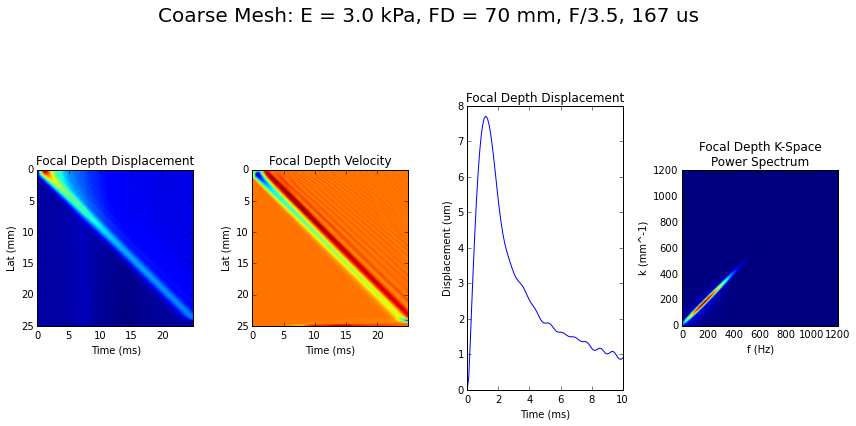

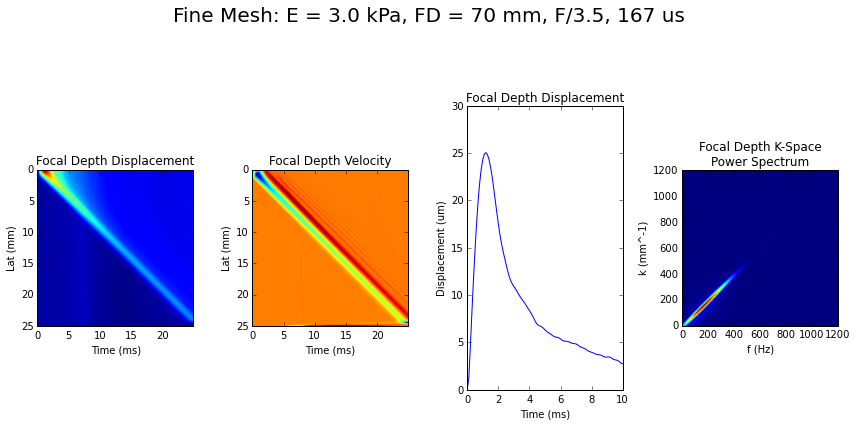

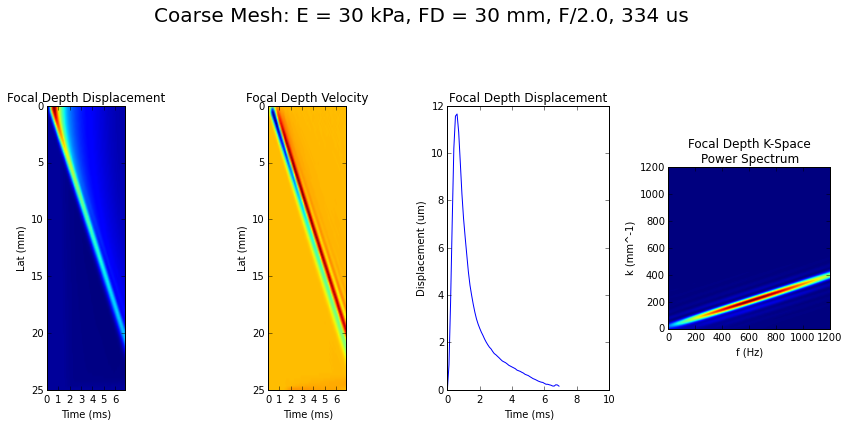

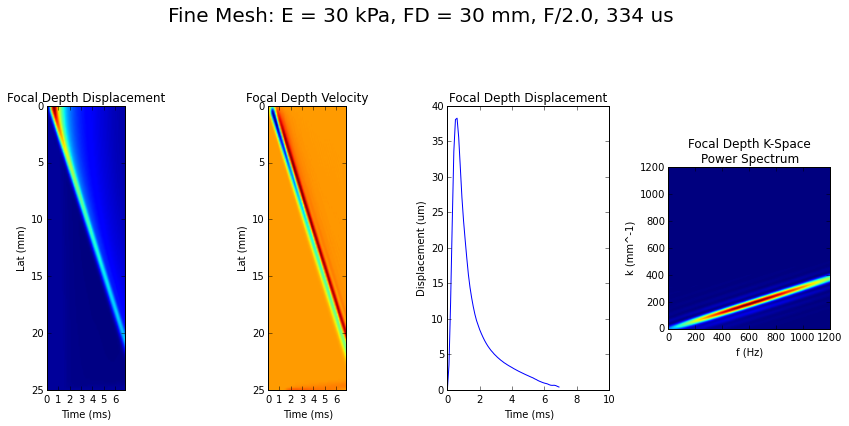

In [88]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

class ResSim:
    """
    calculate vectors and metrics from res_sim.mat datasets for comparative analysis
    """
    def __init__(self, res_sim_mat_path, focalDepth_mm):
        self.res_sim_mat_path = res_sim_mat_path
        self.focalDepth_mm = focalDepth_mm
        self.load_res_sim()
        self.defExtent()
        self.defFocalDepthIndex(focalDepth_mm)
        
    def load_res_sim(self):
        """
        load in axial (mm), lat (mm), t (s) and arfidata (um)
        """
        from scipy.io import loadmat
        loadedData = loadmat(self.res_sim_mat_path)
        self.t = loadedData['t']
        self.axial = loadedData['axial']
        self.lat = loadedData['lat']
        self.arfidata = loadedData['arfidata']
        
    def defExtent(self):
        """
        define extent bounds for images
        """
        self.extent = [self.t.min()*1e3, 
                       self.t.max()*1e3, 
                       self.lat.max(), 
                       self.lat.min()]
        
    def defFocalDepthIndex(self, focalDepth_mm):
        """
        define the index of the focal depth for plotting
        """
        import numpy as np
        self.focalDepthIndex = np.where(self.axial >= focalDepth_mm)[1].min()
                
# load in relevant result files
coarseFoc30mmF2p0_E30k_T334 = ResSim('coarse/Foc30mmF2p0_E30k_T334.mat', 30)
coarseFoc70mmF3p5_E3k_T167 = ResSim('coarse/Foc70mmF3p5_E3k_T167.mat', 70)
fineFoc30mmF2p0_E30k_T334 = ResSim('fine/Foc30mmF2p0_E30k_T334.mat', 30)
fineFoc70mmF3p5_E3k_T167 = ResSim('fine/Foc70mmF3p5_E3k_T167.mat', 70)

def genDispKspacePlots(resObj, title):
    """
    Generate plots of displacement fields and k-space
    """    
    fig, plots =  plt.subplots(1, 4, figsize=(12, 6), dpi=100)
    fig.suptitle(title, fontsize = 20)
    
    plotDispField(resObj, plots, 0)
    plotVelField(resObj, plots, 1)
    plotFocalDepthDisp(resObj, plots, 2)
    plotKspace(resObj, plots, 3)

    fig.tight_layout()
    fig.subplots_adjust(top=0.75)

def plotDispField(resObj, plots, subplotInd):
    plots[subplotInd].imshow(resObj.arfidata[resObj.focalDepthIndex, :, :], extent = resObj.extent)
    plots[subplotInd].set_title('Focal Depth Displacement')
    plots[subplotInd].set_xlabel('Time (ms)')
    plots[subplotInd].set_ylabel('Lat (mm)')

def plotVelField(resObj, plots, subplotInd):
    plots[subplotInd].imshow(np.diff(resObj.arfidata[resObj.focalDepthIndex, :, :], 
                                     n = 1, 
                                     axis = 0), 
                             extent = resObj.extent)
    plots[subplotInd].set_title('Focal Depth Velocity')
    plots[subplotInd].set_xlabel('Time (ms)')
    plots[subplotInd].set_ylabel('Lat (mm)')
    
def plotFocalDepthDisp(resObj, plots, subplotInd):
    plots[subplotInd].plot(resObj.t[0]*1e3, resObj.arfidata[resObj.focalDepthIndex, 0, :])
    plots[subplotInd].set_title('Focal Depth Displacement')
    plots[subplotInd].set_xlabel('Time (ms)')
    plots[subplotInd].set_ylabel('Displacement (um)')
    plots[subplotInd].set_xlim(0, 10)
    
def plotKspace(resObj, plots, subplotInd):
    from scipy import fftpack
    arfivel = np.diff(resObj.arfidata[resObj.focalDepthIndex, :, :], 
                      n = 1, 
                      axis = 0)
    kspace = fftpack.fft2(arfivel, [1024, 1024])
    kspace = fftpack.fftshift(kspace)
    # convert to power
    kspace = np.absolute(kspace)**2
    
    f = np.fft.fftfreq(len(resObj.t[0]), np.mean(np.diff(resObj.t[0])))
    f = fftpack.fftshift(f)
    k = np.fft.fftfreq(len(resObj.lat[0]), np.mean(np.diff(resObj.lat[0])))
    k = fftpack.fftshift(k)*1e3
    
    kExtent = [f.min(), f.max(), k.min(), k.max()]
    
    plots[subplotInd].imshow(kspace, extent = kExtent)
    plots[subplotInd].set_title('Focal Depth K-Space\nPower Spectrum')
    plots[subplotInd].set_xlabel('f (Hz)')
    plots[subplotInd].set_ylabel('k (mm^-1)')
    plots[subplotInd].set_xlim(0, 1200)
    plots[subplotInd].set_ylim(0, 1200)
    
genDispKspacePlots(coarseFoc70mmF3p5_E3k_T167, 'Coarse Mesh: E = 3.0 kPa, FD = 70 mm, F/3.5, 167 us')
genDispKspacePlots(fineFoc70mmF3p5_E3k_T167, 'Fine Mesh: E = 3.0 kPa, FD = 70 mm, F/3.5, 167 us')
genDispKspacePlots(coarseFoc30mmF2p0_E30k_T334, 'Coarse Mesh: E = 30 kPa, FD = 30 mm, F/2.0, 334 us')
genDispKspacePlots(fineFoc30mmF2p0_E30k_T334, 'Fine Mesh: E = 30 kPa, FD = 30 mm, F/2.0, 334 us')

##Discussion
Only 2/48 configurations were tested in this mesh refinement analysis, but I think that we can see the trends that we were interested in.  Most noted in the 3.0 kPa coarse mesh model is the choppy, ringing on the recovery phase of the displacement field, which is reduced in the refined mesh.  This difference did *not* lead to a first-order difference in the primary velocity field spectral energy, and probably would not impact group/phase velocity estimates in these elastic simulations.

The question is if this will rear its head as a confounder in the VE simulations moving forward.  The expense of finer mesh models is 2.5x increase runtime, RAM needs and storage needs, including QIDW upload / download size.

##Conlcusions
The finer mesh (0.1 mm node spacing) reduces some numerical artifact in softer media compared to the coarser mesh (0.25 mm node spacing).  I would recommend doing a similar analysis in the extremes of the VE materials and decide if we can get away with the coarser mesh since we will iterate over more material configurations in that analysis.